<a href="https://colab.research.google.com/github/Rajeeb17/CVPR/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment -1**

In [39]:
import os
import glob
from pathlib import Path

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


Load Dataset & Create Labels

In [40]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Dataset

data_dir = "/content/drive/MyDrive/animal_dataset/animal_dataset"

print("Available Classes:", os.listdir(data_dir))

class_names = sorted(os.listdir(data_dir))
print("Classes:", class_names)

X = []
y = []

for label_idx, cls in enumerate(class_names):
    cls_folder = os.path.join(data_dir, cls)
    image_paths = sorted(glob.glob(os.path.join(cls_folder, "*.jpg")))
    print(f"{cls}: {len(image_paths)} images")

    for img_path in image_paths:
        img = Image.open(img_path)
        img = img.convert("L")
        img = img.resize((32, 32))
        arr = np.array(img, dtype=np.float32)
        arr = arr.flatten()

        X.append(arr)
        y.append(label_idx)

X = np.stack(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class distribution:", np.bincount(y))


Available Classes: ['dog', 'cat', 'panda']
Classes: ['cat', 'dog', 'panda']
cat: 100 images
dog: 100 images
panda: 100 images
X shape: (300, 1024)
y shape: (300,)
Class distribution: [100 100 100]


In [42]:
# Normalize Pixel Values
X = X / 255.0
print("Pixel range after normalization:", X.min(), "to", X.max())


Pixel range after normalization: 0.0 to 1.0


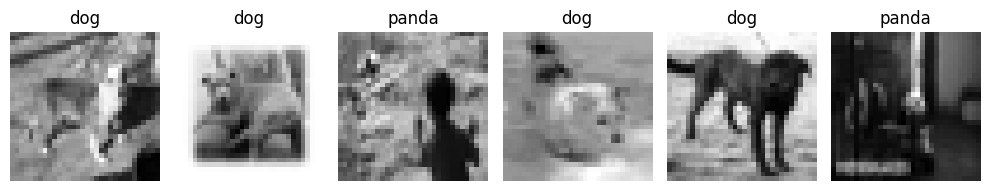

In [43]:
#Random Samples

def show_examples(X, y, class_names, n=6):
    plt.figure(figsize=(10, 3))
    idxs = np.random.choice(len(X), size=n, replace=False)
    for i, idx in enumerate(idxs):
        img = X[idx].reshape(32, 32)
        label = class_names[y[idx]]
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_examples(X, y, class_names, n=6)


In [44]:
# 5-fold Cross-Validation for k-NN

def evaluate_knn(X, y, ks, metric):

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mean_accuracies = []
    all_fold_acc = {k: [] for k in ks}

    for k in ks:
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            all_fold_acc[k].append(acc)

        mean_accuracies.append(np.mean(all_fold_acc[k]))

    return np.array(mean_accuracies), all_fold_acc


In [45]:
# Evaluate k-NN for L1 and L2

ks = list(range(1, 21))  # K = 1..20

l1_mean_acc, l1_folds = evaluate_knn(X, y, ks, metric="manhattan")
l2_mean_acc, l2_folds = evaluate_knn(X, y, ks, metric="euclidean")

print("First 5 L1 mean accuracies:", l1_mean_acc[:5])
print("First 5 L2 mean accuracies:", l2_mean_acc[:5])


First 5 L1 mean accuracies: [0.39666667 0.36333333 0.4        0.41666667 0.41      ]
First 5 L2 mean accuracies: [0.37666667 0.34333333 0.37666667 0.39       0.37666667]


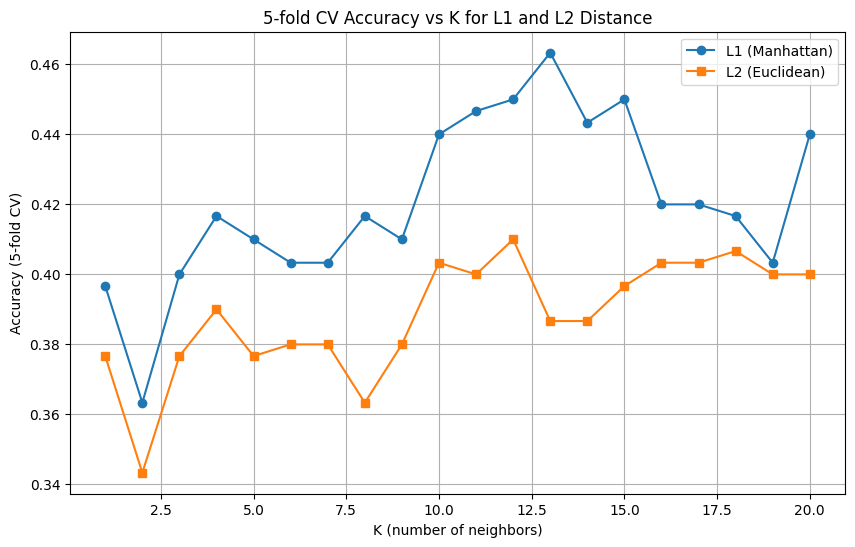

In [46]:
# Plot Accuracy vs K

plt.figure(figsize=(10, 6))
plt.plot(ks, l1_mean_acc, marker='o', label='L1 (Manhattan)')
plt.plot(ks, l2_mean_acc, marker='s', label='L2 (Euclidean)')
plt.xlabel("K (number of neighbors)")
plt.ylabel("Accuracy (5-fold CV)")
plt.title("5-fold CV Accuracy vs K for L1 and L2 Distance")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
# Find Best K and Accuracy

best_idx_l1 = int(np.argmax(l1_mean_acc))
best_k_l1 = ks[best_idx_l1]
best_acc_l1 = l1_mean_acc[best_idx_l1]

best_idx_l2 = int(np.argmax(l2_mean_acc))
best_k_l2 = ks[best_idx_l2]
best_acc_l2 = l2_mean_acc[best_idx_l2]

print(f"Best L1: K = {best_k_l1}, accuracy = {best_acc_l1:.4f}")
print(f"Best L2: K = {best_k_l2}, accuracy = {best_acc_l2:.4f}")


Best L1: K = 13, accuracy = 0.4633
Best L2: K = 12, accuracy = 0.4100


In [48]:
#Train Final Model (use L1 best K)

final_k = best_k_l1
final_metric = "manhattan"

final_model = KNeighborsClassifier(n_neighbors=final_k, metric=final_metric)
final_model.fit(X, y)

print("Trained final model with K =", final_k, "metric =", final_metric)


Trained final model with K = 13 metric = manhattan


In [49]:
#Top Predictions for 5 Test Images

rng = np.random.RandomState(0)
test_indices = rng.choice(len(X), size=5, replace=False)

X_test = X[test_indices]
y_test = y[test_indices]

y_proba = final_model.predict_proba(X_test)
y_pred = final_model.predict(X_test)

print("Class order:", class_names)

for i, idx in enumerate(test_indices):
    probs = y_proba[i]
    sorted_idx = np.argsort(probs)[::-1]

    print(f"\n=== Example {i+1} (index {idx}) ===")
    print("True label     :", class_names[y_test[i]])
    print("Predicted label:", class_names[y_pred[i]])
    print("Class probabilities (top to bottom):")
    for c in sorted_idx:
        print(f"  {class_names[c]}: {probs[c]:.3f}")


Class order: ['cat', 'dog', 'panda']

=== Example 1 (index 208) ===
True label     : panda
Predicted label: panda
Class probabilities (top to bottom):
  panda: 0.615
  cat: 0.231
  dog: 0.154

=== Example 2 (index 188) ===
True label     : dog
Predicted label: cat
Class probabilities (top to bottom):
  cat: 0.538
  dog: 0.385
  panda: 0.077

=== Example 3 (index 12) ===
True label     : cat
Predicted label: cat
Class probabilities (top to bottom):
  cat: 0.615
  dog: 0.385
  panda: 0.000

=== Example 4 (index 221) ===
True label     : panda
Predicted label: dog
Class probabilities (top to bottom):
  dog: 0.462
  cat: 0.385
  panda: 0.154

=== Example 5 (index 239) ===
True label     : panda
Predicted label: dog
Class probabilities (top to bottom):
  dog: 0.462
  cat: 0.308
  panda: 0.231


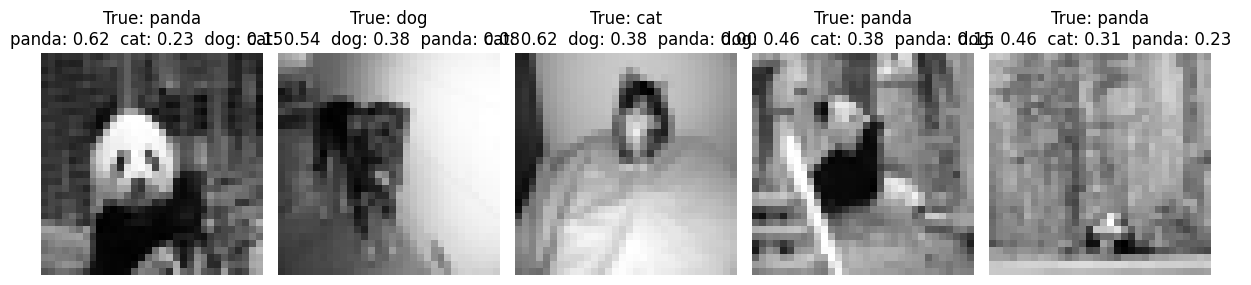

In [50]:
# Test Images with Predictions
plt.figure(figsize=(12, 4))
for i, idx in enumerate(test_indices):
    img = X[idx].reshape(32, 32)
    probs = y_proba[i]
    sorted_idx = np.argsort(probs)[::-1]

    title = f"True: {class_names[y_test[i]]}\n"
    for c in sorted_idx:
        title += f"{class_names[c]}: {probs[c]:.2f}  "

    plt.subplot(1, len(test_indices), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()
